In [2]:
from model import *
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_input = torch.randn(5, 32, 28, 28).to(device)
with torch.no_grad():
    decoder = ENCODER_Decoder(rgb=False).to(device)
    test_output = decoder(test_input)
print("Test output shape:", test_output.shape)


Test output shape: torch.Size([5, 1, 28, 28])


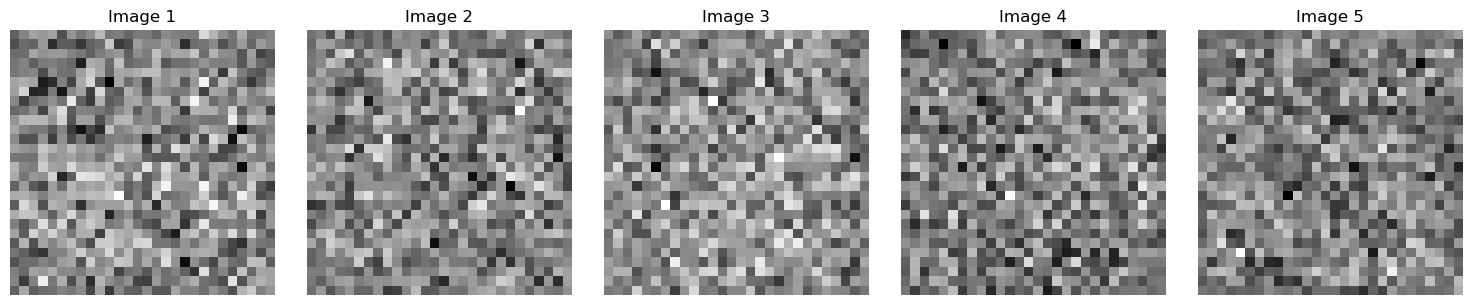

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the decoded tensor is on CPU and converted to numpy
# test_output is expected to have shape (5, 1, 28, 28)
images = test_output.cpu().detach().numpy()  # shape: (5, 1, 28, 28)

# Squeeze the channel dimension so that each image is (28, 28)
images = np.squeeze(images, axis=1)  # shape: (5, 28, 28)

# Plot the 5 images in a single row
plt.figure(figsize=(15, 3))
for i in range(images.shape[0]):
    plt.subplot(1, images.shape[0], i+1)
    plt.imshow(images[i], cmap="gray")
    plt.axis("off")
    plt.title(f"Image {i+1}")
plt.tight_layout()
plt.show()


In [5]:
images[i].shape

(28, 28)

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.31MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.5MB/s]


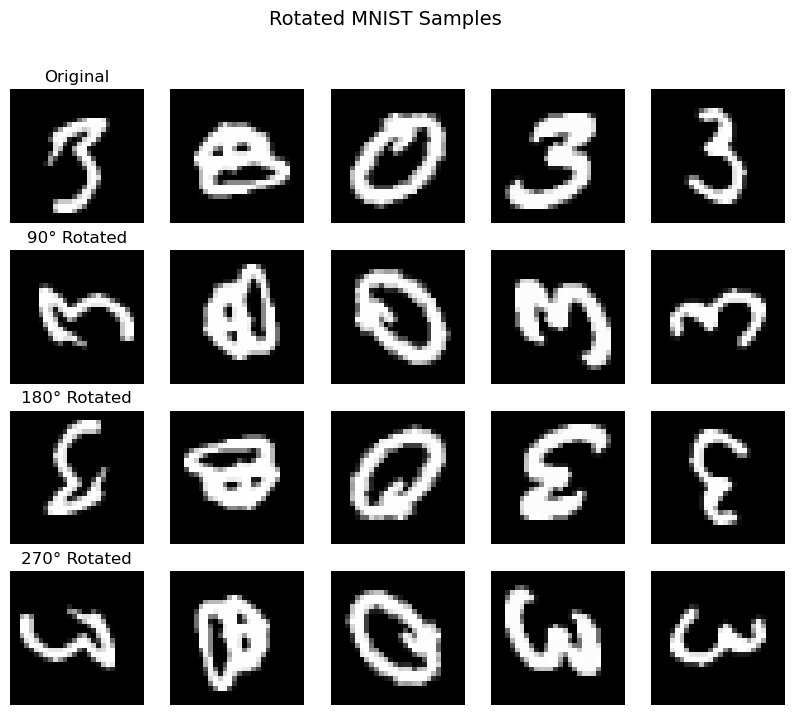

In [6]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Load MNIST dataset for testing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset (only a few samples for visualization)
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=5, shuffle=True)

# Get a batch of images
images, labels = next(iter(mnist_loader))

# Define rotations (90, 180, 270 degrees)
rotated_images_90 = torch.rot90(images, k=1, dims=[2, 3])  # Rotate 90 degrees
rotated_images_180 = torch.rot90(images, k=2, dims=[2, 3])  # Rotate 180 degrees
rotated_images_270 = torch.rot90(images, k=3, dims=[2, 3])  # Rotate 270 degrees

# Plot original and rotated images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Titles
axes[0, 0].set_title("Original", fontsize=12)
axes[1, 0].set_title("90° Rotated", fontsize=12)
axes[2, 0].set_title("180° Rotated", fontsize=12)
axes[3, 0].set_title("270° Rotated", fontsize=12)

# Display images
for i in range(5):
    axes[0, i].imshow(images[i].squeeze(), cmap="gray")
    axes[1, i].imshow(rotated_images_90[i].squeeze(), cmap="gray")
    axes[2, i].imshow(rotated_images_180[i].squeeze(), cmap="gray")
    axes[3, i].imshow(rotated_images_270[i].squeeze(), cmap="gray")

    for j in range(4):
        axes[j, i].axis("off")

plt.suptitle("Rotated MNIST Samples", fontsize=14)
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Step 1: Define Rotation-Linear Feature Extractor
# ----------------------
class RotationInvariantFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=64):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Linear(64 * 7 * 7, feature_dim)  # Flattened feature space
        self.classifier = nn.Linear(feature_dim, 10)  # MNIST has 10 classes

    def forward(self, x):
        x = self.conv_net(x)
        x = x.view(x.size(0), -1)  # Flatten
        z = self.fc(x)  # Feature space representation
        logits = self.classifier(z)  # Classification output
        return z, logits  # Return both feature representation and logits


# ----------------------
# Step 2: Define Rotation Matrix in Latent Space
# ----------------------
def get_rotation_matrix(angle, feature_dim):
    """ Generate a rotation matrix for feature space """
    theta = torch.tensor(angle).float().to("cuda")  # Convert to tensor
    R = torch.eye(feature_dim).to("cuda")  # Identity matrix

    # Apply 2D rotation in the first two dimensions
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    R[:2, :2] = torch.tensor([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

    return R


# ----------------------
# Step 3: Define Loss Functions
# ----------------------
def classification_loss(logits, labels):
    """ Standard cross-entropy loss for digit classification """
    return F.cross_entropy(logits, labels)

def contrastive_loss(features1, features2):
    """ Contrastive loss to ensure digit identity remains consistent across rotations """
    return F.mse_loss(features1, features2)

# ----------------------
# Step 4: Load Original MNIST for Training
# ----------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load original MNIST dataset (train on unrotated images)
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# ----------------------
# Step 5: Train Model on Original MNIST
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
feature_extractor = RotationInvariantFeatureExtractor(feature_dim=64).to(device)
optimizer = optim.Adam(feature_extractor.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        features, logits = feature_extractor(images)

        # Compute classification loss
        loss_cls = classification_loss(logits, labels)

        # Total loss (no rotation loss because training is on unrotated images)
        loss_total = loss_cls

        # Backpropagation
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()

        total_loss += loss_total.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

print("Training completed!")

# ----------------------
# Step 6: Evaluate on Unseen Rotated MNIST Versions
# ----------------------
def test_on_rotated_mnist(rotation_angle):
    """ Apply model trained on original MNIST to a rotated version """
    transform_rotated = transforms.Compose([
        transforms.RandomRotation(degrees=(rotation_angle, rotation_angle)),  # Apply rotation
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load rotated test dataset
    test_dataset = datasets.MNIST(root="./data", train=False, transform=transform_rotated, download=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            _, logits = feature_extractor(images)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    acc = correct / total * 100
    print(f"Test Accuracy on {rotation_angle}° Rotated MNIST: {acc:.2f}%")

# Test the model on unseen rotated MNIST datasets
for angle in [30, 45, 75]:  # Unseen angles
    test_on_rotated_mnist(angle)


Epoch [1/10], Loss: 120.6183
Epoch [2/10], Loss: 42.2496
Epoch [3/10], Loss: 30.4065
Epoch [4/10], Loss: 24.2470
Epoch [5/10], Loss: 18.6877
Epoch [6/10], Loss: 16.5289
Epoch [7/10], Loss: 12.8217
Epoch [8/10], Loss: 11.4582
Epoch [9/10], Loss: 10.3436
Epoch [10/10], Loss: 9.2174
Training completed!
Test Accuracy on 30° Rotated MNIST: 85.52%
Test Accuracy on 45° Rotated MNIST: 60.59%
Test Accuracy on 75° Rotated MNIST: 19.96%


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ----------------------
# Step 1: Define Concept Encoder
# ----------------------
class ConceptEncoder(nn.Module):
    """ Encodes feature space into concept space (Digit Identity + Rotation) """
    def __init__(self, feature_dim=64, concept_dim=32):
        super().__init__()
        self.fc_digit = nn.Linear(feature_dim, concept_dim // 2)  # Digit identity
        self.fc_rotation = nn.Linear(feature_dim, concept_dim // 2)  # Rotation concept

    def forward(self, Z):
        C_digit = self.fc_digit(Z)  # Concept for digit identity
        C_rotation = self.fc_rotation(Z)  # Concept for rotation
        return C_digit, C_rotation


# ----------------------
# Step 2: Define Contrastive Loss for Rotation Consistency
# ----------------------
def contrastive_loss(C_digit_1, C_digit_2):
    """
    Ensures the same digit at different rotations has similar identity features.
    """
    return F.mse_loss(C_digit_1, C_digit_2)


# ----------------------
# Step 3: Define Rotation Mapping Loss
# ----------------------
def rotation_consistency_loss(C_rotation_1, C_rotation_2, theta):
    """
    Ensures that C_rotation follows a learned linear transformation based on rotation angle.
    """
    R = torch.eye(C_rotation_1.shape[1]).to(C_rotation_1.device)  # Identity mapping initially
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)

    # Assume first two dimensions encode rotation
    R[:2, :2] = torch.tensor([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

    predicted_rotation = torch.matmul(R, C_rotation_1.T).T
    return F.mse_loss(predicted_rotation, C_rotation_2)


# ----------------------
# Step 4: Load MNIST Data (Labeled) and 30° Rotated MNIST (Unlabeled)
# ----------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load labeled original MNIST
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Load 30° rotated MNIST (Unlabeled)
transform_rotated = transforms.Compose([
    transforms.RandomRotation(degrees=(30, 30)),  # Rotate by 30°
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
mnist_rotated_dataset = datasets.MNIST(root="./data", train=True, transform=transform_rotated, download=True)
mnist_rotated_loader = DataLoader(mnist_rotated_dataset, batch_size=64, shuffle=True)

# ----------------------
# Step 5: Train Concept Encoder
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
feature_extractor = RotationInvariantFeatureExtractor(feature_dim=64).to(device)
concept_encoder = ConceptEncoder(feature_dim=64, concept_dim=32).to(device)
optimizer = optim.Adam(list(feature_extractor.parameters()) + list(concept_encoder.parameters()), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for (images, labels), (rotated_images, _) in zip(mnist_loader, mnist_rotated_loader):
        images, rotated_images = images.to(device), rotated_images.to(device)

        # Extract features
        Z_original, _ = feature_extractor(images)
        Z_rotated, _ = feature_extractor(rotated_images)

        # Encode concepts
        C_digit_1, C_rotation_1 = concept_encoder(Z_original)
        C_digit_2, C_rotation_2 = concept_encoder(Z_rotated)

        # Compute losses
        loss_contrast = contrastive_loss(C_digit_1, C_digit_2)
        loss_rotation = rotation_consistency_loss(C_rotation_1, C_rotation_2, theta=torch.tensor(30.0).to(device))

        # Total loss
        loss_total = loss_contrast + loss_rotation

        # Backpropagation
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()

        total_loss += loss_total.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

print("Concept learning completed!")


Epoch [1/10], Loss: 0.5272
Epoch [2/10], Loss: 0.0003
Epoch [3/10], Loss: 0.0001
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Concept learning completed!


In [10]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ----------------------
# Step 1: Load Unseen Rotated MNIST Datasets (45°, 60°, 75°)
# ----------------------
def get_rotated_loader(rotation_angle):
    """ Load MNIST rotated by a given angle """
    transform_rotated = transforms.Compose([
        transforms.RandomRotation(degrees=(rotation_angle, rotation_angle)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    mnist_rotated_dataset = datasets.MNIST(root="./data", train=False, transform=transform_rotated, download=True)
    mnist_rotated_loader = DataLoader(mnist_rotated_dataset, batch_size=64, shuffle=False)
    return mnist_rotated_loader

# Define angles for unseen rotations
unseen_angles = [0, 30, 45, 60, 75]

# ----------------------
# Step 2: Evaluate the Model on Unseen Domains
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained models
feature_extractor.eval()
concept_encoder.eval()

def evaluate_on_unseen_rotation(rotation_angle):
    """ Evaluate digit classification and rotation concept learning on unseen angles """
    test_loader = get_rotated_loader(rotation_angle)

    correct_digit = 0
    total_digit = 0
    rotation_errors = 0
    count = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Extract features and encode concepts
            Z, _ = feature_extractor(images)
            C_digit, C_rotation = concept_encoder(Z)

            # Measure digit classification accuracy
            predicted_labels = torch.argmax(C_digit, dim=1)  # Assuming C_digit is used for classification
            correct_digit += (predicted_labels == labels).sum().item()
            total_digit += labels.size(0)

            # Measure rotation concept consistency
            expected_rotation = torch.tensor([rotation_angle] * images.size(0), dtype=torch.float32, device=device)
            rotation_errors += F.mse_loss(C_rotation[:, 0], expected_rotation).item()
            count += 1

    # Compute final scores
    digit_accuracy = correct_digit / total_digit * 100
    rotation_error = rotation_errors / count  # Mean squared error in rotation concept space

    print(f"Evaluation on {rotation_angle}° Rotated MNIST:")
    print(f"  → Digit Classification Accuracy: {digit_accuracy:.2f}%")
    print(f"  → Rotation Concept Error: {rotation_error:.4f}\n")

# Evaluate for each unseen rotation angle
for angle in unseen_angles:
    evaluate_on_unseen_rotation(angle)


Evaluation on 0° Rotated MNIST:
  → Digit Classification Accuracy: 8.92%
  → Rotation Concept Error: 0.0000

Evaluation on 30° Rotated MNIST:
  → Digit Classification Accuracy: 8.92%
  → Rotation Concept Error: 899.9997

Evaluation on 45° Rotated MNIST:
  → Digit Classification Accuracy: 8.92%
  → Rotation Concept Error: 2024.9992

Evaluation on 60° Rotated MNIST:
  → Digit Classification Accuracy: 8.92%
  → Rotation Concept Error: 3599.9990

Evaluation on 75° Rotated MNIST:
  → Digit Classification Accuracy: 8.92%
  → Rotation Concept Error: 5624.9991



Step 5: Analyzing Temporal Sensitivity...


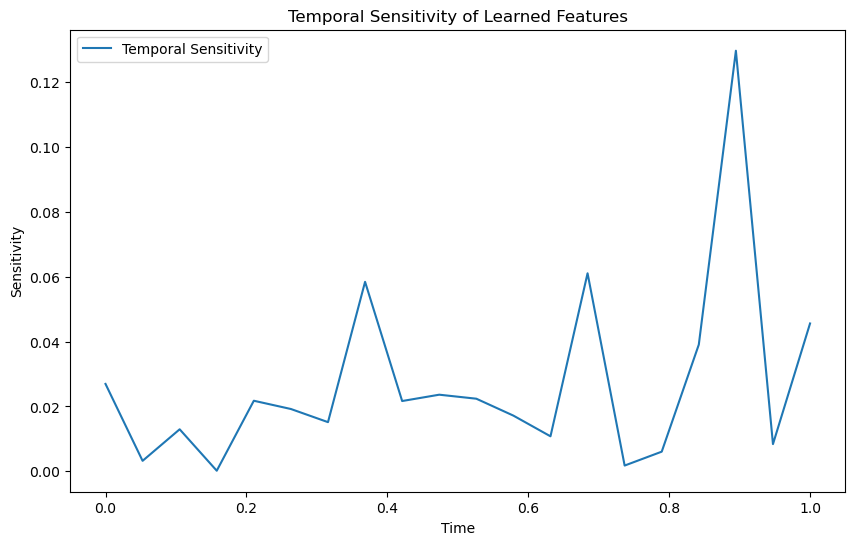

Step 5: Temporal Sensitivity Analysis Complete!


In [8]:
# # Adding print statements to track progress

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# print("Step 1: Generating Simulated Data...")
# # Parameters
# n_samples = 1000
# n_features = 5
# n_time_steps = 20

# # Generate time-independent latent variables
# np.random.seed(42)
# latent_independent = np.random.uniform(-1, 1, size=(n_samples, n_features))

# # Generate time-dependent latent variables
# time = np.linspace(0, 1, n_time_steps)
# latent_dependent = np.array([np.sin(2 * np.pi * time + np.random.uniform(-0.5, 0.5)) for _ in range(n_features)]).T

# # Combine latent variables
# data = np.zeros((n_samples, n_features))
# for i in range(n_samples):
#     t_idx = i % n_time_steps
#     data[i, :] = latent_independent[i, :] + latent_dependent[t_idx, :]

# # Generate time labels (auxiliary variable)
# time_labels = np.repeat(time, n_samples // n_time_steps)

# # Generate shuffled pairs (negative samples for contrastive learning)
# shuffled_indices = np.random.permutation(len(data))
# shuffled_data = data[shuffled_indices]
# shuffled_time_labels = time_labels[shuffled_indices]

# # Create positive and negative samples
# X_positive = np.hstack([data, time_labels.reshape(-1, 1)])
# X_negative = np.hstack([shuffled_data, shuffled_time_labels.reshape(-1, 1)])
# y_positive = np.ones(len(X_positive))
# y_negative = np.zeros(len(X_negative))

# # Combine positive and negative samples
# X = np.vstack([X_positive, X_negative])
# y = np.hstack([y_positive, y_negative])
# print("Step 1: Data Generation Complete!")

# print("Step 2: Splitting Data...")
# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print("Step 2: Data Split Complete!")

# print("Step 3: Training Contrastive Learning Model...")
# # Define a simple MLP classifier as the nonlinear logistic regression model
# model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
# model.fit(X_train, y_train)
# print("Step 3: Model Training Complete!")

# print("Step 4: Evaluating Model...")
# # Evaluate the model
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Contrastive Model Accuracy: {accuracy * 100:.2f}%")

print("Step 5: Analyzing Temporal Sensitivity...")
# Extract learned features
hidden_layer_output = model.predict_proba(X_positive)[:, 1]  # Include all 6 features


# Analyze temporal sensitivity
temporal_sensitivity = np.abs(np.gradient(hidden_layer_output, axis=0))

# Plot temporal sensitivity
plt.figure(figsize=(10, 6))
plt.plot(time, temporal_sensitivity[:n_time_steps], label="Temporal Sensitivity")
plt.xlabel("Time")
plt.ylabel("Sensitivity")
plt.title("Temporal Sensitivity of Learned Features")
plt.legend()
plt.show()
print("Step 5: Temporal Sensitivity Analysis Complete!")


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Step 1: Generate Nonstationary Latent Sources
def generate_nonstationary_sources(n_samples, n_sources, time_steps):
    np.random.seed(42)
    time = np.linspace(0, 1, time_steps)
    latent_sources = np.zeros((n_samples, n_sources))

    for i in range(n_sources):
        variance = np.exp(-((time - np.random.uniform(0.3, 0.7)) ** 2) / (2 * 0.05 ** 2))
        latent_sources[:, i] = np.random.normal(0, np.repeat(variance, n_samples // time_steps))

    return latent_sources, time

# Step 2: Apply Nonlinear Mixing
def nonlinear_mixing(latent_sources):
    n_samples, n_sources = latent_sources.shape
    mix_matrix = np.random.randn(n_sources, n_sources)
    nonlinear_mix = np.tanh(latent_sources @ mix_matrix.T)  # Nonlinear mixing
    return nonlinear_mix

# Step 3: Generate Contrastive Learning Samples
def generate_contrastive_samples(data, auxiliary_variable):
    n_samples = len(data)
    shuffled_indices = np.random.permutation(n_samples)
    data_negative = data[shuffled_indices]
    auxiliary_negative = auxiliary_variable[shuffled_indices]

    # Positive samples: (data, auxiliary_variable)
    positive_samples = np.hstack([data, auxiliary_variable.reshape(-1, 1)])
    # Negative samples: (shuffled_data, shuffled_auxiliary)
    negative_samples = np.hstack([data_negative, auxiliary_negative.reshape(-1, 1)])

    # Labels: 1 for positive, 0 for negative
    X = np.vstack([positive_samples, negative_samples])
    y = np.hstack([np.ones(n_samples), np.zeros(n_samples)])

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Step 4: Define PyTorch Contrastive Model
class ContrastiveNN(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes):
        super(ContrastiveNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_layer_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_layer_sizes[1], hidden_layer_sizes[2]),
            nn.ReLU()
        )
        self.classifier = nn.Linear(hidden_layer_sizes[2], 2)  # Output layer for classification (2 classes)

    def forward(self, x, return_features=False):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        if return_features:
            return features
        return logits

# Step 5: Train PyTorch Model
def train_contrastive_model(model, train_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

            # Track accuracy
            epoch_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")
    return model

# Step 6: Extract Features for Evaluation
def extract_hidden_features(model, data_loader):
    model.eval()
    features_list = []

    with torch.no_grad():
        for batch_x, _ in data_loader:
            features = model(batch_x, return_features=True)  # Extract hidden features
            features_list.append(features.numpy())

    return np.vstack(features_list)

# Step 7: Evaluate Hidden Features Against Latent Sources
def evaluate_features(hidden_features, latent_sources):
    print("\nCorrelation Between Hidden Features and Latent Sources:")
    for i in range(latent_sources.shape[1]):
        corr = np.corrcoef(hidden_features[:, i], latent_sources[:, i])[0, 1]
        print(f"Feature {i+1} vs. Source {i+1}: Correlation = {corr:.2f}")

# Simulation Parameters
n_samples = 10000
n_sources = 3
time_steps = 100

# Generate Nonstationary Latent Sources
latent_sources, time = generate_nonstationary_sources(n_samples, n_sources, time_steps)

# Apply Nonlinear Mixing
mixed_data = nonlinear_mixing(latent_sources)

# Generate Contrastive Learning Samples
X, y = generate_contrastive_samples(mixed_data, np.tile(time, n_samples // time_steps))

# Split into Training and Testing Sets
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Train Contrastive Learning Model
print("Training Contrastive Learning Model...")
input_size = X.shape[1]
model = ContrastiveNN(input_size, hidden_layer_sizes=[64, 32, 16])
model = train_contrastive_model(model, train_loader, epochs=10)
print("Training Complete!")

# Extract Hidden Features
print("Extracting Hidden Features...")
hidden_features = extract_hidden_features(model, test_loader)

# Evaluate Hidden Features Against Latent Sources
print("Evaluating Hidden Features...")
evaluate_features(hidden_features, latent_sources)

# Plot Original and Hidden Features
plt.figure(figsize=(12, 6))
for i in range(n_sources):
    plt.subplot(n_sources, 1, i + 1)
    plt.plot(latent_sources[:, i], label="Original Source")
    plt.plot(hidden_features[:, i], label="Learned Feature", alpha=0.7)
    plt.legend()
plt.suptitle("Original Sources vs. Learned Features")
plt.show()


Training Contrastive Learning Model...
Epoch [1/10], Loss: 86.7150, Accuracy: 50.22%
Epoch [2/10], Loss: 86.6516, Accuracy: 50.04%
Epoch [3/10], Loss: 86.6540, Accuracy: 50.14%
Epoch [4/10], Loss: 86.6559, Accuracy: 50.08%
Epoch [5/10], Loss: 86.6621, Accuracy: 49.47%
Epoch [6/10], Loss: 86.6567, Accuracy: 49.54%
Epoch [7/10], Loss: 86.6537, Accuracy: 49.98%
Epoch [8/10], Loss: 86.6551, Accuracy: 49.44%
Epoch [9/10], Loss: 86.6595, Accuracy: 49.54%
Epoch [10/10], Loss: 86.6525, Accuracy: 49.74%
Training Complete!
Extracting Hidden Features...
Evaluating Hidden Features...

Correlation Between Hidden Features and Latent Sources:


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4000 and the array at index 1 has size 10000